In [6]:
# %pip install dmba
# %pip install category_encoders
# %pip install lightgbm
# %pip install xgboost

In [55]:
import os
import os.path as osp
from os.path import curdir
from datetime import datetime

import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from dmba import classificationSummary
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             balanced_accuracy_score, matthews_corrcoef)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
# Adjust Pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')


### Load Train Data, Train Label, and Test Data

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
curdir = '/content/drive/MyDrive/Colab Notebooks/Earthquake'
# earthquake_train_values_csv_path = osp.join(curdir,'train_values.csv')
# earthquake_train_labels_csv_path = osp.join(curdir,'train_labels.csv')
# earthquake_train_values_csv_path = osp.join(curdir,'train_values.csv')

earthquake_train_labels_csv_path = '/content/drive/MyDrive/Colab Notebooks/Earthquake/train_labels.csv'
earthquake_train_values_csv_path = '/content/drive/MyDrive/Colab Notebooks/Earthquake/train_values.csv'
earthquake_test_values_csv_path = '/content/drive/MyDrive/Colab Notebooks/Earthquake/test_values.csv'


In [12]:
earthquake_train_x_data_raw = pd.read_csv(earthquake_train_values_csv_path, index_col='building_id')
earthquake_train_y_data_raw = pd.read_csv(earthquake_train_labels_csv_path, index_col='building_id')
earthquake_test_x_data_raw = pd.read_csv(earthquake_test_values_csv_path, index_col='building_id')

earthquake_data_raw = pd.merge(earthquake_train_x_data_raw, earthquake_train_y_data_raw, left_index=True, right_index=True)

### Dictionary Setup to Store Model Results

In [13]:
# Set up the dictionary of classifiers
classifiers = dict()
classifiers['logistic_regression'] = LogisticRegression(solver='saga', multi_class='multinomial', random_state=42, verbose=0)
classifiers['knn'] = KNeighborsClassifier(n_jobs=-1)
classifiers['lightgbm'] = LGBMClassifier(objective='multiclass', num_class=3, random_state=42, verbose=-1)
classifiers['random_forest'] = RandomForestClassifier(random_state=42, verbose=0)
classifiers['xgboost'] = XGBClassifier(objective='multi:softprob', num_class=3, random_state=42)
classifiers['stacking'] = StackingClassifier(estimators=[
    ('lgbm', classifiers['lightgbm']), ('xgb', classifiers['xgboost'])], final_estimator=classifiers['random_forest'])

In [14]:
# Set up the dictionary to save the trained models
trained_models = dict()
for model_name, model in classifiers.items():
    model_name = type(model).__name__
    trained_models[model_name] = dict(model_estimator=None, model_best_score=0,
                                 model_best_parameters=None, model_split_test_scores=None, model_duration=None)
trained_models

{'LogisticRegression': {'model_estimator': None,
  'model_best_score': 0,
  'model_best_parameters': None,
  'model_split_test_scores': None,
  'model_duration': None},
 'KNeighborsClassifier': {'model_estimator': None,
  'model_best_score': 0,
  'model_best_parameters': None,
  'model_split_test_scores': None,
  'model_duration': None},
 'LGBMClassifier': {'model_estimator': None,
  'model_best_score': 0,
  'model_best_parameters': None,
  'model_split_test_scores': None,
  'model_duration': None},
 'RandomForestClassifier': {'model_estimator': None,
  'model_best_score': 0,
  'model_best_parameters': None,
  'model_split_test_scores': None,
  'model_duration': None},
 'XGBClassifier': {'model_estimator': None,
  'model_best_score': 0,
  'model_best_parameters': None,
  'model_split_test_scores': None,
  'model_duration': None},
 'StackingClassifier': {'model_estimator': None,
  'model_best_score': 0,
  'model_best_parameters': None,
  'model_split_test_scores': None,
  'model_duratio

In [15]:
# Set up the dictionary to save the best-performing model
best_candidate = dict()
best_candidate['model_name'] = None
best_candidate['model_estimator'] = None
best_candidate['model_best_score'] = 0
best_candidate['model_best_parameters'] = None
best_candidate['model_split_test_scores'] = None
best_candidate['model_duration'] = None
best_candidate

{'model_name': None,
 'model_estimator': None,
 'model_best_score': 0,
 'model_best_parameters': None,
 'model_split_test_scores': None,
 'model_duration': None}

### Training Data Preprocessing (100%)

In [16]:
# Preprocessing
earthquake_data = earthquake_data_raw.copy()

target = 'damage_grade'
train_X = earthquake_data.drop(columns=[target])
train_y = earthquake_data[target]

# Encode labels to be zero-indexed
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)

# Group features based on data type
geo_level_categorical_features = train_X.columns[train_X.columns.str.startswith(('geo_level'))]
categorical_features = train_X.select_dtypes(include=['object']).columns
binary_features = train_X.columns[train_X.isin([0,1]).all()]
integer_features = train_X.select_dtypes(include=['int64', 'float64']).columns
numeric_features = integer_features.difference(binary_features).difference(geo_level_categorical_features)
print("Geo level categorical features: {}.".format(geo_level_categorical_features))
print("Categorical features: {}.".format(categorical_features))
print("Binary features: {}.".format(binary_features))
print("Integer features: {}.".format(integer_features))
print("Numeric features: {}.".format(numeric_features))

# Convert geo_level_id features and object-typed features to category type
for col in [geo_level_categorical_features, categorical_features]:
    train_X[col] = train_X[col].astype('category')

print(train_X.shape)
print(train_y.shape)

Geo level categorical features: Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], dtype='object').
Categorical features: Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object').
Binary features: Index(['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secon

### Define Helper Functions

In [57]:
# Define the custom transformer using FunctionTransformer
def get_dummies_transform(X):
    return pd.get_dummies(X, drop_first=True)

dummies_transformer = FunctionTransformer(get_dummies_transform, validate=False)

# Create a ColumnTransformer that applies get_dummies to columns 'A' and 'C'
column_transformer = ColumnTransformer(
    transformers=[
        ('dummies', dummies_transformer, categorical_features),
    ],
    remainder='passthrough'  # Keep other columns unchanged
)




def get_feature_selector(X, y, base_model, threshold="mean"):
    selector = SelectFromModel(estimator=base_model, threshold=threshold)
    selector.fit(X, y)
    return selector



In [58]:
# Define a custom transformer that conditionally applies the preprocessor
class ConditionalPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor=None):
        self.preprocessor = preprocessor

    def fit(self, X, y=None):
        if self.preprocessor:
            self.preprocessor.fit(X, y)
        return self

    def transform(self, X):
        if self.preprocessor:
            return self.preprocessor.transform(X)
        return X

# # Function to create a pipeline with conditional preprocessing
# def create_pipeline(classifier, preprocessor=None):
#     steps = [
#         ('conditional_preprocessor', ConditionalPreprocessor(preprocessor=preprocessor)),
#         ('classifier', classifier)
#     ]
#     return Pipeline(steps)


# Function to create a pipeline with conditional preprocessing and feature selection
def create_pipeline(classifier, preprocessor=None, feature_selector=None):
    steps = []

    if preprocessor is not None:
        steps.append(('conditional_preprocessor', ConditionalPreprocessor(preprocessor=preprocessor)))

    if feature_selector is not None:
        steps.append(('feature_selector', feature_selector))

    steps.append(('classifier', classifier))
    return Pipeline(steps)

def grid_search_on_pipline_and_time(X_train, y_train, preprocessor, feature_selector, model, param_grid):
    # df_pandas = preprocessor.fit_transform(X_train, y_train)
    # print(df_pandas.shape)
    steps = list()
    steps.append(('preprocessor', preprocessor))
    steps.append(('feature_selector', feature_selector))
    steps.append(('classifier', model))
    # print(steps)

    pipeline = model
    # if preprocessor is not None:
    #     pipeline = Pipeline(steps)
    #     print("Preprocessor pipline is used.")


    if preprocessor is not None or feature_selector is not None:
        pipeline = Pipeline(steps)
        print("Pipeline with preprocessor and/or feature selector is used.")

    # Fit the pipeline on the training data
    start_time = datetime.now()

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_micro')
    grid_search.fit(X_train, y_train)
    end_time = datetime.now()
    duration = end_time - start_time
    print('Duration: {}'.format(duration))

    # Get the index of the best parameter combination
    best_index = grid_search.best_index_
    # Extract the scores for each fold for the best parameter combination
    split_test_scores = [grid_search.cv_results_[f'split{i}_test_score'][best_index] for i in range(grid_search.cv)]

    # Save the trained model
    model_name = type(model).__name__
    trained_models[model_name]['model_estimator'] = grid_search
    trained_models[model_name]['model_best_score'] = grid_search.best_score_
    trained_models[model_name]['model_best_score'] = grid_search.best_score_
    trained_models[model_name]['model_best_parameters'] = grid_search.best_params_
    trained_models[model_name]['model_split_test_scores'] = split_test_scores
    trained_models[model_name]['model_duration'] = duration

    # Find the best-performing model
    if (best_candidate['model_name'] is None) or (best_candidate['model_best_score'] < grid_search.best_score_):
        best_candidate['model_name'] = model_name
        best_candidate['model_estimator'] = grid_search
        best_candidate['model_best_score'] = grid_search.best_score_
        best_candidate['model_best_parameters'] = grid_search.best_params_
        best_candidate['model_split_test_scores'] = split_test_scores
        best_candidate['model_duration'] = duration

    return grid_search

### Model Training
### Logistic Regression

In [19]:
# Logistic regression, normalize integer-typed features, one hot encode object-typed features and geo_level_ids
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features.union(geo_level_categorical_features))
    ],
    remainder='passthrough')

clf = classifiers['logistic_regression']
default_params = clf.get_params()
print('Model default parameter: ', default_params)

param_grid = {}
gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor, clf, param_grid)
print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Preprocessor pipline is used.
Duration: 0:00:34.029878
Mean fit time:  [15.76395006]
Mean test score:  [0.74156661]
Best Score:  0.7415666086955139  Best Params:  {}


### KNN

In [20]:
# KNN, normalize integer-typed features, one hot encode object-typed features and target encode geo_level_ids
target_encoding_features = geo_level_categorical_features[:3]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('target_encoder', TargetEncoder(), target_encoding_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough')

clf = classifiers['knn']
default_params = clf.get_params()
print('Model default parameter: ', default_params)

param_grid = {
    'classifier__n_neighbors': [24,25,26]
}
gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor, clf, param_grid)
print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Preprocessor pipline is used.
Duration: 0:01:28.637553
Mean fit time:  [0.6847712  0.88201113 0.81495008]
Mean test score:  [0.70757979 0.70834341 0.70831271]
Best Score:  0.7083434088954973  Best Params:  {'classifier__n_neighbors': 25}


### LightGBM

In [21]:
# # LightGBM, no encoding for object-typed features and geo_level_ids
# preprocessor = None
# clf = classifiers['lightgbm']
# default_params = clf.get_params()
# print('Model default parameter: ', default_params)

# param_grid = {}
# gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor, clf, param_grid)
# print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
# print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_class': 3, 'verbose': -1}
Duration: 0:11:49.016612
Mean fit time:  [695.53009591]
Mean test score:  [0.7485543]
Best Score:  0.7485542985658129  Best Params:  {}


In [22]:
# # LightGBM, one hot encode object-typed features and target encode geo_level_ids
# target_encoding_features = geo_level_categorical_features[:3]
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('target_encoder', TargetEncoder(), target_encoding_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ],
#     remainder='passthrough')

# clf = classifiers['lightgbm']
# default_params = clf.get_params()
# print('Model default parameter: ', default_params)

# param_grid = {}
# gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor, clf, param_grid)
# print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
# print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
# print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_class': 3, 'verbose': -1}
Preprocessor pipline is used.
Duration: 0:04:33.736161
Mean fit time:  [258.29014797]
Mean test score:  [0.73659732]
Best Score:  0.7365973215875574  Best Params:  {}


In [23]:
# LightGBM, no encoding for object-typed features and geo_level_ids, grid search paramter n_estimators
preprocessor = None
param_grid = {
  # 'bagging_fraction': [0.8],
  # 'bagging_freq': [0],
  # 'boosting_type': ['gbdt'],
  # 'colsample_bytree': [1.0],
  # 'feature_fraction': [0.8],
  # 'lambda_l1': [0.1],
  # 'lambda_l2': [0.1],
  # 'learning_rate': [0.1],
  # 'max_bin': [300],
  # 'max_depth': [-1],
  # 'min_child_samples': [20],
  # 'min_child_weight': [0.001],
  # 'min_split_gain': [0.0],
  'n_estimators': [100, 200, 300, 400, 600, 800],
  # 'class_weight': [None],
  # 'num_leaves': [31],
  # 'reg_alpha': [0.0],
  # 'reg_lambda': [0.0],
  # 'scale_pos_weight': [1],
  # 'subsample': [1.0]
}

clf = classifiers['lightgbm']+
default_params = clf.get_params()
print('Model default parameter: ', default_params)

gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor, clf, param_grid)
print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_class': 3, 'verbose': -1}
Duration: 6:13:36.940300
Mean fit time:  [ 4798.31639824 10132.69390593 13643.13924971 16490.59282131
 19711.63165874 16623.70276022]
Mean test score:  [0.7485543  0.74830104 0.74813987 0.7476794  0.74667787 0.74613681]
Best Score:  0.7485542985658129  Best Params:  {'n_estimators': 100}


### Random Forest

In [62]:
# Random forest, binary encode object-typed features and target encode geo_level_ids
target_encoding_features = geo_level_categorical_features[:3]

preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', TargetEncoder(), target_encoding_features),
        ('dummies', dummies_transformer, categorical_features)
    ],
    remainder='passthrough')
#selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100))
selector = None
clf = classifiers['random_forest']
default_params = clf.get_params()
print('Model default parameter: ', default_params)

param_grid = {}
gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor,selector,clf, param_grid)
print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Pipeline with preprocessor and/or feature selector is used.
Duration: 0:01:11.377749
Mean fit time:  [30.96234226]
Mean test score:  [0.73285598]
Best Score:  0.7328559773016515  Best Params:  {}


### XGBoost

In [25]:
# XGBoost, one hot encode object-typed features and target encode geo_level_ids
target_encoding_features = geo_level_categorical_features[:3]

preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', TargetEncoder(), target_encoding_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough')

clf = classifiers['xgboost']
default_params = clf.get_params()
print('Model default parameter: ', default_params)

param_grid = {}
gridSearch = grid_search_on_pipline_and_time(train_X, train_y, preprocessor, clf, param_grid)
print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Model default parameter:  {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 3}
Preprocessor pipline is used.
Durati

### Stacking Classifier with Logistic Regression, lightGBM, Random Forest, XGBoost

In [26]:
# # Stacking Classifier
# # LR: normalize integer-typed features, one hot encode object-typed features and target encode geo_level_ids
# # RF & XGB: one hot encode object-typed features and target encode geo_level_ids
# # LGBM: no encoding for object-typed features and geo_level_ids
# target_encoding_features = geo_level_categorical_features[:3]

# preprocessor_1 = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('target_encoder', TargetEncoder(), target_encoding_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ],
#     remainder='passthrough')

# preprocessor_2 = ColumnTransformer(
#     transformers=[
#         ('target_encoder', TargetEncoder(), target_encoding_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ],
#     remainder='passthrough')

# pipeline_lr = create_pipeline(classifiers['logistic_regression'], preprocessor=preprocessor_1)
# pipeline_rf = create_pipeline(classifiers['random_forest'], preprocessor=preprocessor_2)
# pipeline_xgb = create_pipeline(classifiers['xgboost'], preprocessor=preprocessor_2)
# pipeline_lgbm = create_pipeline(classifiers['lightgbm'])

# # Combine pipelines in a StackingClassifier
# clf = StackingClassifier(estimators=[
#     ('lr', pipeline_lr),
#     ('lgbm', pipeline_lgbm),
#     ('rf', pipeline_rf),
#     ('xgb', pipeline_xgb)], final_estimator=classifiers['lightgbm'])

# param_grid = {}
# gridSearch = grid_search_on_pipline_and_time(train_X, train_y, None, clf, param_grid)
# print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
# print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
# print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

In [27]:
# Stacking Classifier
# LR: normalize integer-typed features, one hot encode object-typed features and target encode geo_level_ids
# RF & XGB: one hot encode object-typed features and target encode geo_level_ids
# LGBM: no encoding for object-typed features and geo_level_ids, parameter n_estimator=400
target_encoding_features = geo_level_categorical_features[:3]

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('target_encoder', TargetEncoder(), target_encoding_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough')

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('target_encoder', TargetEncoder(), target_encoding_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough')

pipeline_lr = create_pipeline(classifiers['logistic_regression'], preprocessor=preprocessor_1)
pipeline_rf = create_pipeline(classifiers['random_forest'], preprocessor=preprocessor_2)
pipeline_xgb = create_pipeline(classifiers['xgboost'], preprocessor=preprocessor_2)
pipeline_lgbm = create_pipeline(classifiers['lightgbm'])

# Combine pipelines in a StackingClassifier
clf = StackingClassifier(estimators=[
    ('lr', pipeline_lr),
    ('lgbm', pipeline_lgbm),
    ('rf', pipeline_rf),
    ('xgb', pipeline_xgb)], final_estimator=classifiers['lightgbm'])

param_grid = {
    'lgbm__classifier__n_estimators': [400],
}
gridSearch = grid_search_on_pipline_and_time(train_X, train_y, None, clf, param_grid)
print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

Duration: 2:31:13.454674
Mean fit time:  [7507.81606102]
Mean test score:  [0.75223425]
Best Score:  0.7522342492408339  Best Params:  {'lgbm__classifier__n_estimators': 400}


### Stacking Classifier with LightGBM, Random Forest, XGBoost

In [28]:
# # Stacking Classifier
# # RF & XGB: one hot encode object-typed features and target encode geo_level_ids
# # LGBM: no encoding for object-typed features and geo_level_ids, grid search parameter n_estimators
# target_encoding_features = geo_level_categorical_features[:3]

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('target_encoder', TargetEncoder(), target_encoding_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ],
#     remainder='passthrough')

# pipeline_rf = create_pipeline(classifiers['random_forest'], preprocessor=preprocessor)
# pipeline_xgb = create_pipeline(classifiers['xgboost'], preprocessor=preprocessor)
# pipeline_lgbm = create_pipeline(classifiers['lightgbm'])

# # Combine pipelines in a StackingClassifier
# clf = StackingClassifier(estimators=[
#     ('lgbm', pipeline_lgbm),
#     ('rf', pipeline_rf),
#     ('xgb', pipeline_xgb)], final_estimator=classifiers['lightgbm'])

# param_grid = {
#     'lgbm__classifier__n_estimators': [100,400],
# }
# gridSearch = grid_search_on_pipline_and_time(train_X, train_y, None, clf, param_grid)
# print('Mean fit time: ', gridSearch.cv_results_['mean_fit_time'])
# print('Mean test score: ', gridSearch.cv_results_['mean_test_score'])
# print('Best Score: ', gridSearch.best_score_, ' Best Params: ', gridSearch.best_params_)

### Best Model Classification Report

In [29]:
print(classification_report(train_y, best_candidate['model_estimator'].predict(train_X), output_dict=False, zero_division=0))
print(classificationSummary(train_y, best_candidate['model_estimator'].predict(train_X)))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76     25124
           1       0.82      0.92      0.87    148259
           2       0.87      0.73      0.80     87218

    accuracy                           0.84    260601
   macro avg       0.85      0.78      0.81    260601
weighted avg       0.84      0.84      0.83    260601

Confusion Matrix (Accuracy 0.8357)

       Prediction
Actual      0      1      2
     0  17288   7678    158
     1   2522 136793   8944
     2    323  23202  63693
None


### Logistic Regression Features of Importance

In [30]:
coefficients = trained_models['LogisticRegression']['model_estimator'].best_estimator_._final_estimator.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance_results = list(zip(train_X,avg_importance))
feature_importance_df = pd.DataFrame(feature_importance_results, columns = ["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(15)
feature_importance_df

,Feature,Importance
27,has_secondary_use,1.568821
28,has_secondary_use_agriculture,1.277213
37,has_secondary_use_other,1.023853
29,has_secondary_use_hotel,0.900129
23,has_superstructure_rc_engineered,0.877192
15,has_superstructure_mud_mortar_stone,0.786772
31,has_secondary_use_institution,0.748550
18,has_superstructure_mud_mortar_brick,0.725798
32,has_secondary_use_school,0.672633
11,other_floor_type,0.640315


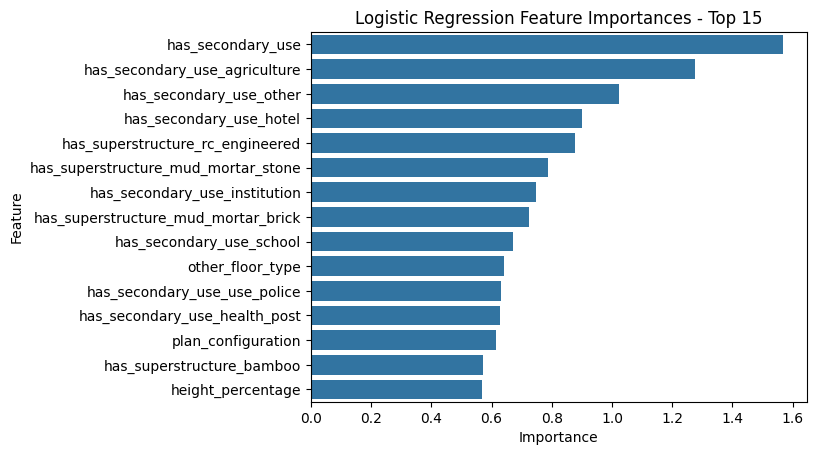

In [31]:
title = "Logistic Regression Feature Importances - Top 15"
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.Feature, orient='h').set_title(title)
plt.show()

### LightGBM Features of Importance

In [32]:
feature_importance_results = list(zip(train_X,trained_models['LGBMClassifier']['model_estimator'].best_estimator_.feature_importances_))
feature_importance_df = pd.DataFrame(feature_importance_results, columns = ["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(15)
feature_importance_df

,Feature,Importance
2,geo_level_3_id,5485
1,geo_level_2_id,2382
4,age,206
0,geo_level_1_id,192
5,area_percentage,80
8,foundation_type,76
11,other_floor_type,71
26,count_families,67
15,has_superstructure_mud_mortar_stone,62
10,ground_floor_type,57


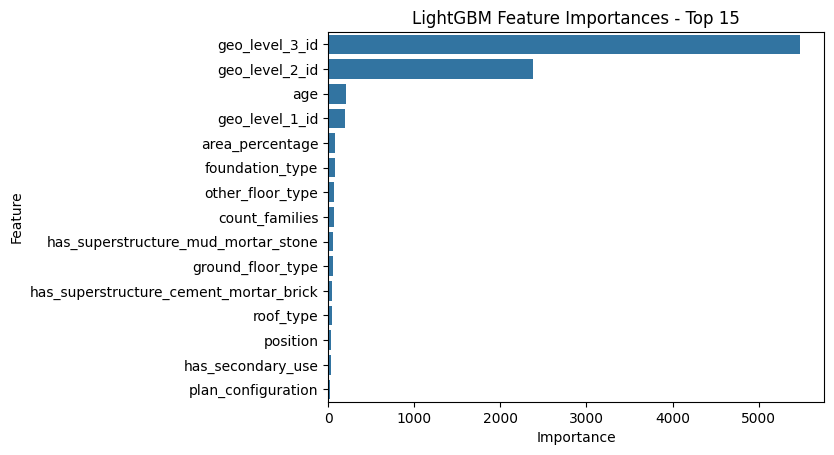

In [33]:
title = "LightGBM Feature Importances - Top 15"
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.Feature, orient='h').set_title(title)
plt.show()

### Random Forest Features of Importance

In [34]:
feature_importance_results = list(zip(train_X, trained_models['RandomForestClassifier']['model_estimator'].best_estimator_.\
                                      _final_estimator.feature_importances_))
feature_importance_df = pd.DataFrame(feature_importance_results, columns = ["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(15)
feature_importance_df

,Feature,Importance
2,geo_level_3_id,0.254500
1,geo_level_2_id,0.163150
34,has_secondary_use_health_post,0.108392
35,has_secondary_use_gov_office,0.099279
0,geo_level_1_id,0.083195
36,has_secondary_use_use_police,0.048430
33,has_secondary_use_industry,0.016536
9,roof_type,0.013054
4,age,0.012306
6,height_percentage,0.009528


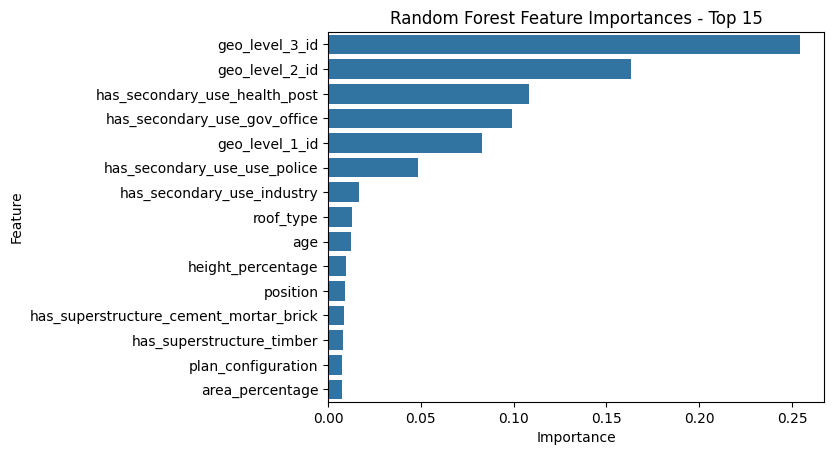

In [35]:
title = "Random Forest Feature Importances - Top 15"
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.Feature, orient='h').set_title(title)
plt.show()

### XGBoost Features of Importance

In [36]:
feature_importance_results = list(zip(train_X, trained_models['XGBClassifier']['model_estimator'].best_estimator_.\
                                      _final_estimator.feature_importances_))
feature_importance_df = pd.DataFrame(feature_importance_results, columns = ["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(15)
feature_importance_df

,Feature,Importance
2,geo_level_3_id,0.159208
13,plan_configuration,0.135852
7,land_surface_condition,0.101034
16,has_superstructure_stone_flag,0.085345
8,foundation_type,0.077567
19,has_superstructure_cement_mortar_brick,0.026638
1,geo_level_2_id,0.021239
0,geo_level_1_id,0.014190
21,has_superstructure_bamboo,0.011981
20,has_superstructure_timber,0.011729


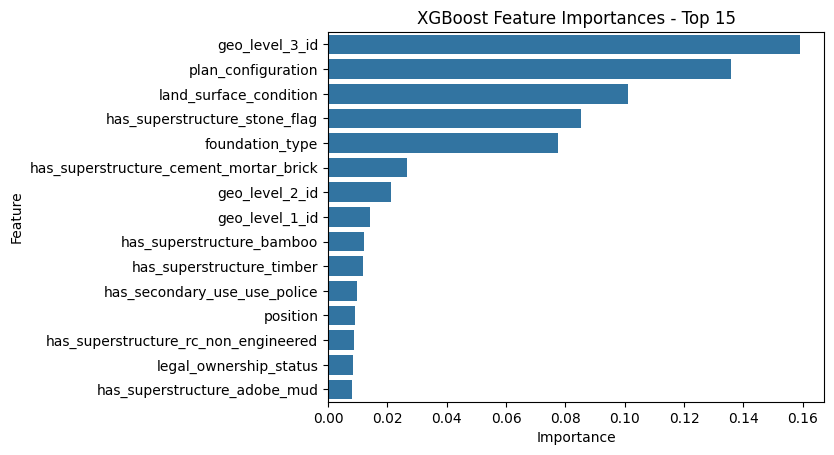

In [37]:
title = "XGBoost Feature Importances - Top 15"
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.Feature, orient='h').set_title(title)
plt.show()

### Model F1 Micro CV Score Boxplot

In [38]:
trained_models_df = pd.DataFrame(columns=['Model Name', 'Best Average CV Score', 'Best Hyper-Parameters', '5-fold CV Scores', 'Training Duration',
                                          'Leader Board Score', 'Display Order'])
leader_board_score = [0.7397, 0.7477, 0.7343, 0.7400, 0.7524, 0.7115]
display_order = [0,2,3,4,5,1]
for i, key in enumerate(trained_models):
    trained_models_df.loc[i] = [
        key,
        trained_models[key]['model_best_score'],
        trained_models[key]['model_best_parameters'],
        trained_models[key]['model_split_test_scores'],
        trained_models[key]['model_duration'],
        leader_board_score[i],
        display_order[i],
    ]
# trained_models_df = trained_models_df.set_index('model_name')
trained_models_df = trained_models_df.sort_values(by=['Display Order'])
trained_models_df

,Model Name,Best Average CV Score,Best Hyper-Parameters,5-fold CV Scores,Training Duration,Leader Board Score,Display Order
0,LogisticRegression,0.741567,{},"[0.7417739490800254, 0.7370107444359171, 0.744...",0 days 00:00:34.029878,0.7397,0
5,StackingClassifier,0.752234,{'lgbm__classifier__n_estimators': 400},"[0.7546478386830644, 0.7477168073676131, 0.753...",0 days 02:31:13.454674,0.7115,1
1,KNeighborsClassifier,0.708343,{'classifier__n_neighbors': 25},"[0.7076418334260662, 0.7062739831158864, 0.710...",0 days 00:01:28.637553,0.7477,2
2,LGBMClassifier,0.748554,{'n_estimators': 100},"[0.749793749160607, 0.7438795088257867, 0.7509...",0 days 06:13:36.940300,0.7343,3
3,RandomForestClassifier,0.732856,{},"[0.7323151896548417, 0.7287413660782809, 0.735...",0 days 00:01:05.482126,0.7400,4
4,XGBClassifier,0.739970,{},"[0.7400088256173135, 0.7369723714504989, 0.742...",0 days 00:00:11.517830,0.7524,5


### Model F1 Micro CV Score Barplot

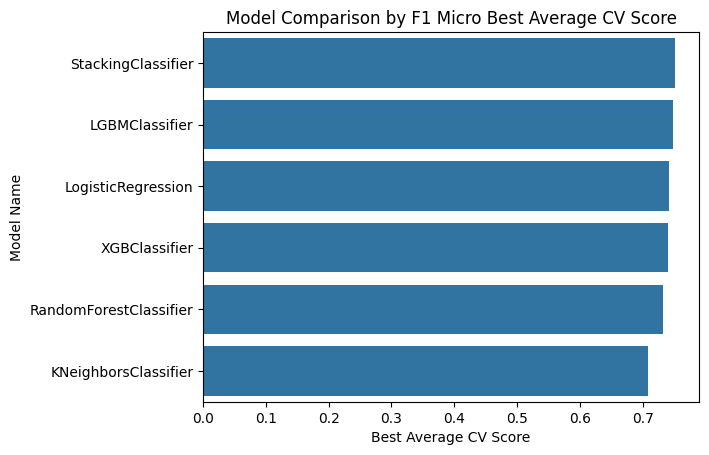

In [40]:
title = "Model Comparison by F1 Micro Best Average CV Score"
trained_models_df_best_score_descending = trained_models_df.sort_values(by=['Best Average CV Score'], ascending=False)
sns.barplot(x=trained_models_df_best_score_descending['Best Average CV Score'],
            y=trained_models_df_best_score_descending['Model Name'], orient='h').set_title(title)
plt.show()

### Model F1 Micro Leader Board Score Barplot

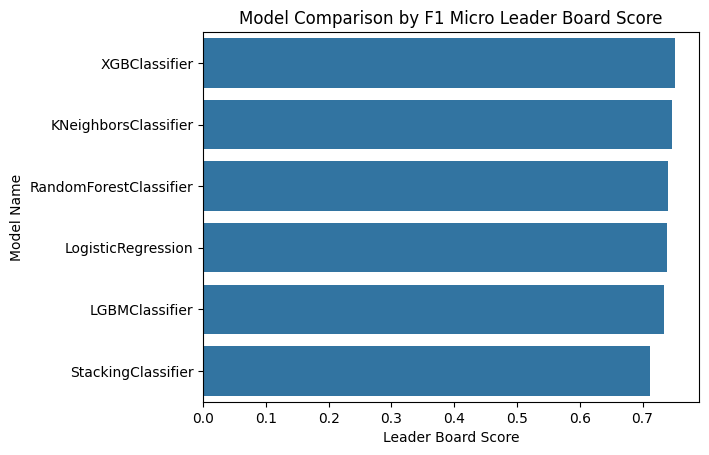

In [41]:
title = "Model Comparison by F1 Micro Leader Board Score"
trained_models_df_lb_score_descending = trained_models_df.sort_values(by=['Leader Board Score'], ascending=False)
sns.barplot(x=trained_models_df_lb_score_descending['Leader Board Score'],
            y=trained_models_df_lb_score_descending['Model Name'], orient='h').set_title(title)
plt.show()

### Model Performance Assessment

In [42]:
print('Logistic regression best score: {}.'.format(trained_models['LogisticRegression']['model_best_score']))
print('KNN best score: {}.'.format(trained_models['KNeighborsClassifier']['model_best_score']))
print('LightGBM best score: {}.'.format(trained_models['LGBMClassifier']['model_best_score']))
print('Random forest best score: {}.'.format(trained_models['RandomForestClassifier']['model_best_score']))
print('XGBoost best score: {}.'.format(trained_models['XGBClassifier']['model_best_score']))
print('Stacking classifier best score: {}.'.format(trained_models['StackingClassifier']['model_best_score']))

Logistic regression best score: 0.7415666086955139.
KNN best score: 0.7083434088954973.
LightGBM best score: 0.7485542985658129.
Random forest best score: 0.7328559773016515.
XGBoost best score: 0.7399702992754198.
Stacking classifier best score: 0.7522342492408339.


In [43]:
print(best_candidate['model_name'])
print(best_candidate['model_best_score'])
print(best_candidate['model_best_parameters'])
print(best_candidate['model_split_test_scores'])
print(best_candidate['model_duration'])

StackingClassifier
0.7522342492408339
{'lgbm__classifier__n_estimators': 400}
[np.float64(0.7546478386830644), np.float64(0.7477168073676131), np.float64(0.7535111281657713), np.float64(0.7525709900230237), np.float64(0.7527244819646969)]
2:31:13.454674


In [44]:
best_candidate['model_estimator']

GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('lr',
                                                       Pipeline(steps=[('conditional_preprocessor',
                                                                        ConditionalPreprocessor(preprocessor=ColumnTransformer(remainder='passthrough',
                                                                                                                               transformers=[('num',
                                                                                                                                              StandardScaler(),
                                                                                                                                              Index(['age', 'area_percentage', 'count_families', 'count_floors_pre_eq',
       'height_percentage'],
      dtype='object')),
                                                                                                                                             ('target_encoder...
                                                                                      max_delta_step=None,
                                                                                      max_depth=None,
                                                                                      max_leaves=None,
                                                                                      min_child_weight=None,
                                                                                      missing=nan,
                                                                                      monotone_constraints=None,
                                                                                      multi_strategy=None,
                                                                                      n_estimators=None,
                                                                                      n_jobs=None,
                                                                                      num_class=3, ...))]))],
                                          final_estimator=LGBMClassifier(num_class=3,
                                                                         objective='multiclass',
                                                                         random_state=42,
                                                                         verbose=-1)),
             n_jobs=-1, param_grid={'lgbm__classifier__n_estimators': [400]},
             scoring='f1_micro')

In [45]:
trained_models

{'LogisticRegression': {'model_estimator': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('num',
                                                                           StandardScaler(),
                                                                           Index(['age', 'area_percentage', 'count_families', 'count_floors_pre_eq',
         'height_percentage'],
        dtype='object')),
                                                                          ('cat',
                                                                           OneHotEncoder(handle_unknown='ignore'),
                                                                           Index(['foundation_type', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
         'ground_floor_type', 'land_surface_condition', 'legal

### Test Data Preprocessing

In [46]:
# Convert geo_level_id features and object-typed features to category type
earthquake_test_x_data = earthquake_test_x_data_raw.copy()
categorical_features = earthquake_test_x_data_raw.select_dtypes(include=['object']).columns
for col in [geo_level_categorical_features, categorical_features]:
    earthquake_test_x_data[col] = earthquake_test_x_data[col].astype('category')

In [47]:
# Predictions
best_model = best_candidate['model_estimator']
best_model_name = best_candidate['model_name']
# best_model = trained_models['StackingClassifier']['model_estimator']
# best_model_name = type(best_model.best_estimator_._final_estimator).__name__
# best_model_name = type(best_model.best_estimator_).__name__
predictions_encoded = best_model.predict(earthquake_test_x_data)
predictions = label_encoder.inverse_transform(predictions_encoded)

predictions = predictions.astype(int)

In [48]:
print(best_model_name)
print(best_model.best_score_)

StackingClassifier
0.7522342492408339


In [49]:
test_building_id = earthquake_test_x_data_raw.index.to_numpy()

In [50]:
print(earthquake_test_x_data_raw.index.shape)
print(predictions.shape)
print(test_building_id.shape)

(86868,)
(86868,)
(86868,)


In [53]:
now = datetime.now()
current_timestamp = now.strftime('%Y-%m-%dT%H-%M-%S')
print(best_model_name)
print(current_timestamp)
submission_csv_path = osp.join(curdir,'default-{}-model-submission-{}.csv'.format(best_model_name, current_timestamp))

StackingClassifier
2025-07-22T01-21-11


In [54]:
# Create Submission File
submission = pd.DataFrame()
submission["building_id"] = test_building_id
submission["damage_grade"] = predictions
# print(submission.head(1))
submission.to_csv(submission_csv_path, index=False)